In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from keras.models import Model
import keras.backend as K
import keras.applications.vgg16 as vgg16
import keras.applications.vgg19 as vgg19
import keras.applications.resnet50 as res
import keras.applications.inception_v3 as inc
import keras.applications.xception as xce
from keras.applications.xception import preprocess_input as preproc_xce
from grade_classif.imports import *

Using TensorFlow backend.


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [ ]:
# export
class Extractor:

    def __init__(self, cnn_architecture="xception", layer="output", patchsize=299):

        self.network_name = cnn_architecture
        self.layer_name = layer

        self.get_network_characteristics(patchsize)

        print("Feature extractor: %s // %s" % (self.network_name, self.layer_name))

    def get_network_characteristics(self, patchsize):

        if self.network_name == "vgg16":

            base_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "vgg19":
            base_model = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "resnet":
            base_model = res.ResNet50(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "xception":
            base_model = xce.Xception(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        elif self.network_name == "inception":
            base_model = inc.InceptionV3(include_top=False, weights='imagenet', input_shape=(patchsize, patchsize, 3), pooling='avg')
            if self.layer_name == "output":
                self.model = Model(inputs=base_model.input, outputs=base_model.output)
            else:
                self.model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer_name).output)

        else:
            print("Error: possible network names:\n-'vgg16'\n-'vgg19'\n-'resnet'\n-'xception'\n-'inception'")

    def extract(self, images):
        features = self.model.predict(images)
        return np.array([np.ndarray.flatten(f) for f in features])

    def load_weights(self, weight_path):
        self.model.load_weights(weight_path)
        print("Loaded weights from: {}".format(weight_path))

In [ ]:
extractor = Extractor()

Feature extractor: xception // output


In [ ]:
extractor.load_weights('/data/DeepLearning/ABREU_Arnaud/PUL/NST/xception/niv1_test2/weights/iter_12.h5')

Loaded weights from: /data/DeepLearning/ABREU_Arnaud/PUL/NST/xception/niv1_test2/weights/iter_12.h5


In [ ]:
df = pd.read_csv('/data/DeepLearning/ABREU_Arnaud/NST_PACS/WS_Clustering/SlidesMining/28_10_2019/most_significant_descriptor.csv')

In [ ]:
from grade_classif.data.dataset import ImageClassifDataset
from grade_classif.params.parser import hparams

In [ ]:
data = ImageClassifDataset.from_folder(hparams.data, lambda x: x.parts[-3], classes = ['1', '3'])

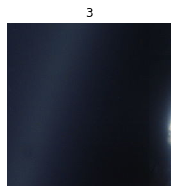

In [ ]:
data.show(-1)

In [ ]:
garb = [38743,
        38778,
        38792,
        38797,
        39304,
        40288,
        40290]

In [ ]:
ok = [40749,
      41149,
      41177,
      41289,
      41509,
      41587,
      41591,
      41796,
      42728,
      42886,
      43439,
      44344,
      44455]

In [ ]:
x, _ = data[-1]

In [ ]:
x = cv2.resize(x, (299, 299), cv2.INTER_LINEAR)

In [ ]:
ft = extractor.extract(np.expand_dims(x, 0))[0]

In [ ]:
concepts = []
vectors = []
for k, row in df.iterrows():
    conc = int(row['Concept'])
    if conc in garb+ok:
        concepts.append(conc)
        vectors.append(row.values[1:])

In [ ]:
concepts = np.array(concepts)

In [ ]:
vectors = np.expand_dims(vectors, 0)

In [ ]:
batch = []
items = []
scores = []
for k, (x, _) in tqdm(enumerate(data), total=len(data)):
    batch.append(cv2.resize(x, (299, 299), cv2.INTER_LINEAR))
    items.append(data.items[k])        
    if len(batch)==16:
        batch = np.stack(batch)
        fts = np.expand_dims(extractor.extract(batch), 1)
        scores.append(((vectors-fts)**2).sum(-1))
        batch = []
if len(batch) > 0:
        batch = np.stack(batch)
        fts = np.expand_dims(extractor.extract(batch), 1)
        scores.append(((vectors-fts)**2).sum(-1))
scores = np.concatenate(scores)

100%|██████████| 608439/608439 [1:51:58<00:00, 90.56it/s]  


In [ ]:
np.save(hparams.data/'distances.npy', scores)

In [ ]:
np.save(hparams.data/'items', np.array(items))

In [ ]:
best_idxs = np.argmin(scores, axis=-1)

In [ ]:
conc_df = pd.DataFrame({'patchId': list(map(lambda x: x.stem, items)), 'concept': concepts[best_idxs]})

In [ ]:
conc_df.to_csv(hparams.data/'concepts.csv', index=False)

In [ ]:
garb_items = [items[i] for i in range(len(items)) if concepts[best_idxs][i] in garb]

In [ ]:
from grade_classif.data.utils import show_img

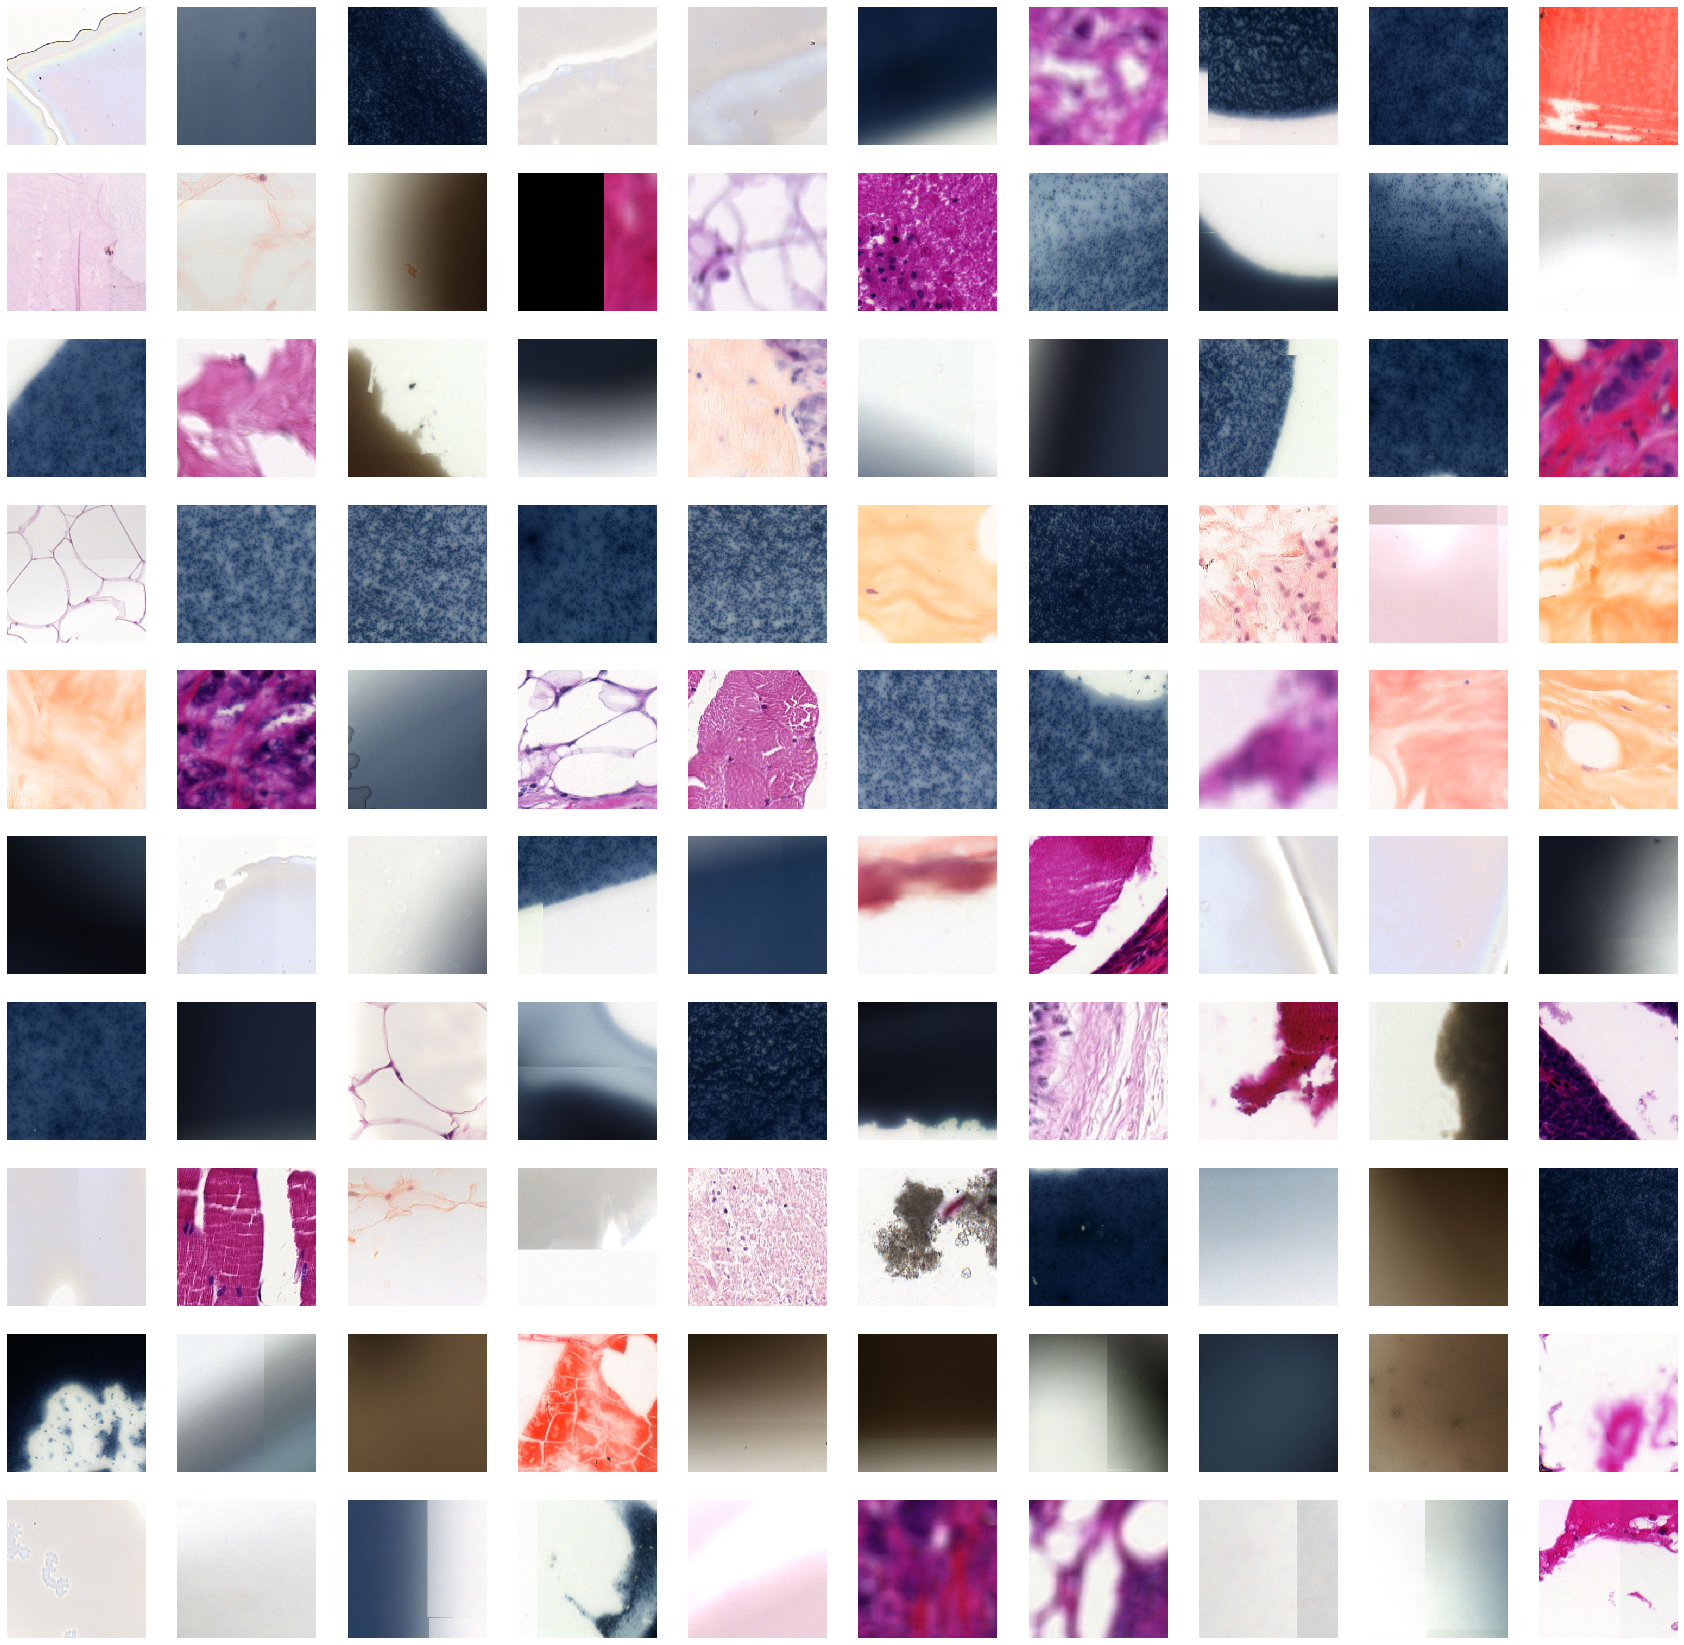

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))
for ax in axs.flatten():
    i = np.random.randint(len(garb_items))
    fn = garb_items[i]
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')

In [ ]:
from grade_classif.params.parser import hparams
from grade_classif.data.dataset import ImageClassifDataset
df = pd.read_csv(hparams.data/'concepts.csv')
data = ImageClassifDataset.from_folder(hparams.data, lambda x: x.parts[-3], include=['1', '3'], classes=['1', '3'])

In [ ]:
scans_df = pd.read_csv(hparams.full_data/'scans.csv')

In [ ]:
concept = df['concept'].unique()[2]; concept

44455

In [ ]:
for concept in df['concept'].unique():
    print(concept, df.loc[df['concept']==concept].shape[0])

43439 38557
44344 27655
44455 121437
42886 75274
41796 32174
41177 57351
40290 18513
42728 46695
41591 23942
41289 36316
41149 33895
41587 17786
41509 50666
40288 7513
40749 15968
39304 335
38797 3497
38743 864
38778 1


In [ ]:
stats = df.groupby(lambda x: df['patchId'][x][7:9])

In [ ]:
res={}
for group in stats.groups:
    pacs_df = df.loc[stats.groups[group]]
    print(group, pacs_df.shape[0]/df.shape[0])
    res[group] = {}
    for concept in df['concept'].unique():
        pacs_df.loc[pacs_df['concept']==concept].shape[0]
        res[group][concept] = pacs_df.loc[pacs_df['concept']==concept].shape[0]/df.loc[df['concept']==concept].shape[0]

04 0.47017038684239504
05 0.19475740378246628
08 0.33507220937513865


In [ ]:
df_no_garb = df.loc[df['concept'].isin(ok)]

In [ ]:
stats_no_garb = df_no_garb.groupby(lambda x: df_no_garb['patchId'][x][7:9])

In [ ]:
for group in stats_no_garb.groups:
    pacs_df = df_no_garb.loc[stats_no_garb.groups[group]]
    print(group, pacs_df.shape[0]/df_no_garb.shape[0])

04 0.4851155238906314
05 0.19838467343815994
08 0.3164998026712087


In [ ]:
stats_scans = scans_df.groupby(lambda x: scans_df['scan'][x][7:9])

In [ ]:
for group in stats_scans.groups:
    pacs_df = scans_df.loc[stats_scans.groups[group]]
    print(group, pacs_df.shape[0]/scans_df.shape[0])

04 0.5013333333333333
05 0.20444444444444446
08 0.2942222222222222


In [ ]:
pd.DataFrame(res).to_csv(hparams.data/'stats.csv')

In [ ]:
def patch_to_fn(patch_id):
    scan = '_'.join(patch_id.split('_')[:-2])
    grade = str(scans_df.loc[scans_df['scan']==scan, 'grade'].values[0])
    path = hparams.data/grade/scan/(patch_id+'.png')
    return path

In [ ]:
items = list(map(patch_to_fn, df.loc[df['concept']==concept, 'patchId'].values))

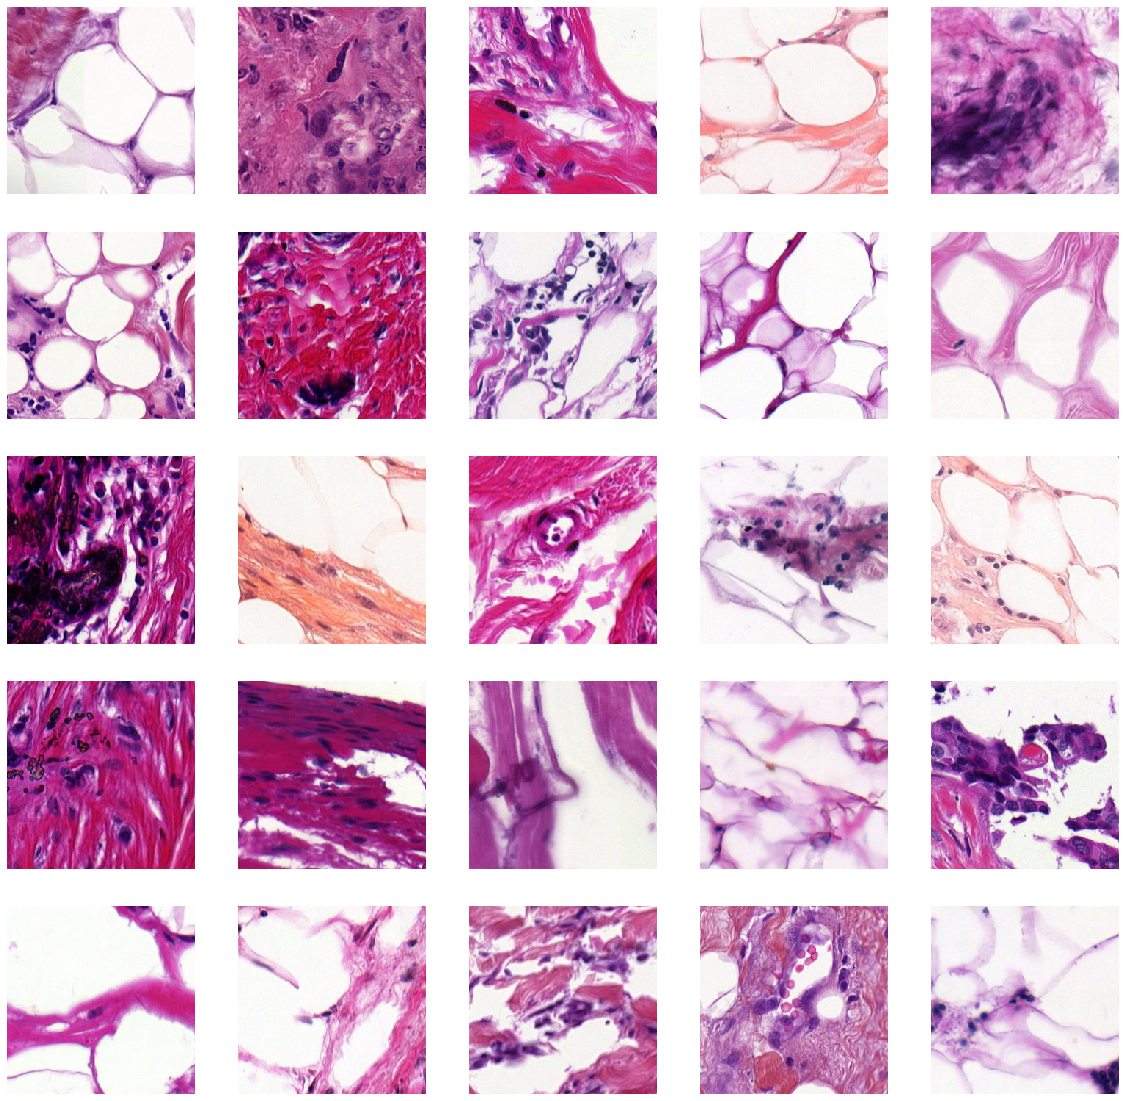

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for ax in axs.flatten():
    fn = np.random.choice(items)
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    show_img(img, ax=ax)

In [ ]:
for item in garb_items:
    item.rename(hparams.full_data/'garbage/level_1'/item.name)

In [ ]:
score = 0
for i in idxs:
    score += 2*(float(concepts[i] in ok)-0.5)/dists[i]